In [70]:
import matplotlib.pyplot as plt 
import os 
import glob
import numpy
import pandas
import seaborn as sns

In [71]:
data_dir = f'{os.getcwd()}/trained_results/'

In [72]:
print(data_dir)

/mnt/e/Cambridge/experimental_results/exp_results3/trained_results/


In [73]:
def get_results(result_files, filter=False):
    rewards = []
    u_rewards = []
    steps = []
    test_reward = []
    for r in result_files:
        # print(r)
        try:
            data = pandas.read_csv(r)
            # print(r)
            # print(data)
            # print(len(data['test_reward']))
            idx = len(data['test_reward']) - 1
            rewards.append(data['test_reward'][idx])
        except:
            pass

        try:
            u_rewards.append(data['u_reward'].tolist())
            steps.append(data['total_num_steps'].tolist())
            test_reward.append(data['test_reward'].tolist())
        except:
            pass

    return (rewards, u_rewards, steps, test_reward)

In [74]:
def load_results(n_demo, env, warm, alpha):
    # Expert results -----------------
    expert_results = glob.glob(f'{data_dir}/expert/expert_{env}_seed=*.perf')
    (expert_reward, _, _, _) = get_results(expert_results)

    # Behavior Cloing results --------
    bc_mse_results = glob.glob(f'{data_dir}/bc/bc_{env}_policy_ntrajs={n_demo}_seed=*.perf')
    (bc_mse_reward, _, _,_) = get_results(bc_mse_results)

    # DRIL results -------------------
    exp_name  = f'dril_{env}_ntraj={n_demo}_ensemble_lr=0.00025_lr=0.00025_bcep=1000_'
    exp_name += f'shuffle=sample_w_replace_quantile=0.98_warm={warm}_alpha={alpha}_cost_-1_to_1_seed=*.perf'
    # dril_Walker2DBulletEnv-v0_ntraj=3_ensemble_lr=0.00025_lr=0.00025_bcep=1000_shuffle=sample_w_replace_quantile=0.98_warm=True_alpha=0.25_cost_-1_to_1_seed=1
    
    # data_dir = '/mnt/e/Cambridge/experimental_results/trained_results'
    # print(data_dir)
    # bc_mse_variance_results = glob.glob('/mnt/e/Cambridge/*')
    # print('a',bc_mse_variance_results)
    # print(f'{data_dir}/dril/{exp_name}')
    # print(bc_mse_variance_results)

    bc_mse_variance_results = glob.glob(f'{data_dir}/dril/{exp_name}')
    (bc_mse_variance_reward, bc_variance_u_reward, bc_variance_steps, bc_mse_variance_reward_curve) = get_results(bc_mse_variance_results, filter=True)
    
    # Random results -----------------
    # random_reward = []
    # random_results = glob.glob(f'{data_dir}/random/{env}/random*.perf')
    # for r in random_results:
    #     random_reward.append(pandas.read_csv(r)['test_reward'].max())

    # # Gail results --------------------
    # params = [(clipped_loss, zero_expert_reward, use_obs_norm, use_bc,      gail_normalized_reward, bc_loss, clamp_gail_action)
    #      for clipped_loss in [True]
    #      for zero_expert_reward in [True, False]
    #      for use_obs_norm in [False]
    #      for use_bc in [True]
    #      for gail_normalized_reward in [True]
    #      for clamp_gail_action in [False]
    #      for bc_loss in ['mse']]

    # # gail = {}
    # # for gail_reward_type in ['unbias', 'favor_zero_reward', 'favor_non_zero_reward']:
    # #     gail_results  = f'gail_{env}_ntraj={n_demo}_'
    # #     gail_results += f'gail_lr=0.001_lr=0.00025_bcep=2001_'
    # #     gail_results += f'gail_reward_type={gail_reward_type}_seed=*.perf'
    # #     results = glob.glob(f'{data_dir}/gail/{gail_results}')

    # #     label = f'GAIL {gail_reward_type}'
    # #     (results, _, _, _) = get_results(results)
    # #     if results:
    # #         gail[label] = results
    # #     else:
    # #         gail[label] = []

    return { 'expert': numpy.array(expert_reward),
             'bc_mse': numpy.array(bc_mse_reward),
            'bc_mse_variance': numpy.array(bc_mse_variance_reward),
            'bc_variance_u_reward_curve': bc_variance_u_reward,
            'bc_mse_variance_reward_curve': bc_mse_variance_reward_curve,
            'bc_variance_steps': bc_variance_steps,
            #'random': numpy.array(random_reward),
            }

In [75]:
# DRIL ------------------
bc_mse_variance = {False:load_results(3, "Walker2DBulletEnv-v0", "False", "1"), True:load_results(3, "Walker2DBulletEnv-v0", "True", "1")}

In [76]:
# def compute_mean_and_std(arr_bundle):
    

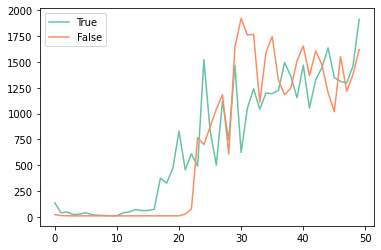

In [77]:
plt.plot(bc_mse_variance[True]['bc_mse_variance_reward_curve'][2], label='True')
plt.plot(bc_mse_variance[False]['bc_mse_variance_reward_curve'][2], label="False")
plt.legend()
plt.show()
# plt.plto
# plt.plot(bc_mse_variance)
# plt.plot(bc_mse_variance[0]['bc_mse_variance_reward_curve'][1])


In [78]:
mean_bc_mse_variance1 = numpy.mean(bc_mse_variance[True]['bc_mse_variance_reward_curve'], axis=0)
mean_bc_mse_variance2 = numpy.mean(bc_mse_variance[False]['bc_mse_variance_reward_curve'], axis=0)

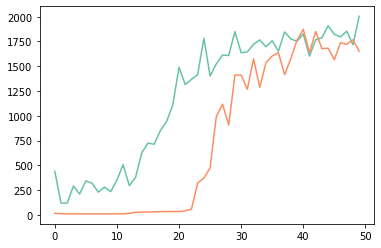

In [79]:
plt.plot(mean_bc_mse_variance1)
plt.plot(mean_bc_mse_variance2)

In [80]:
def plot_with_conf(raw_arr1, raw_arr2, title, ylabel):
    mean_arr = numpy.mean(raw_arr1, axis=0)
    std_arr = numpy.std(raw_arr1, axis=0)


    mean_arr2 = numpy.mean(raw_arr2, axis=0)
    std_arr2 = numpy.std(raw_arr2, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    # ax.set_fon
    # Plot mean line
    ax.plot(mean_arr, label='BC+DRIL')
    ax.plot(mean_arr2, label="DRIL")
    # Plot confidence intervals
    lower_bound = mean_arr - std_arr
    upper_bound = mean_arr + std_arr
    ax.fill_between(range(len(mean_arr)), lower_bound, upper_bound, alpha=0.2)

    lower_bound2 = mean_arr2 - std_arr2
    upper_bound2 = mean_arr2 + std_arr2
    ax.fill_between(range(len(mean_arr2)), lower_bound2, upper_bound2, alpha=0.2)

    ax.plot()
    # Add legend and axis labels
    ax.legend()
    ax.set_xlabel('timesteps*6000', size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.set_title(title, size=16)
    # Show plot
    plt.show()

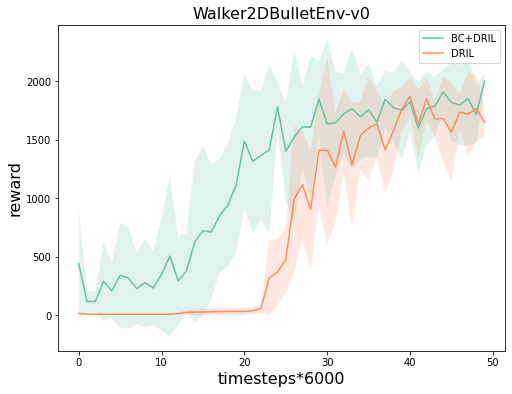

In [81]:
plot_with_conf(bc_mse_variance[True]['bc_mse_variance_reward_curve'], bc_mse_variance[False]['bc_mse_variance_reward_curve'], "Walker2DBulletEnv-v0", "reward")

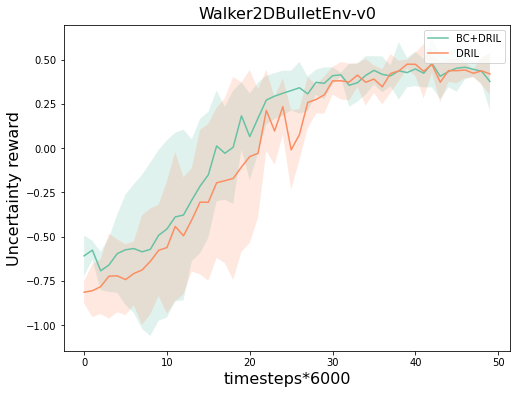

In [82]:
plot_with_conf(bc_mse_variance[True]['bc_variance_u_reward_curve'], bc_mse_variance[False]['bc_variance_u_reward_curve'], "Walker2DBulletEnv-v0", "Uncertainty reward")

In [83]:
results_alpha_walker = {"alpha-0.25":load_results(3, "Walker2DBulletEnv-v0", "True", "0.25"), "alpha-0.5":load_results(3, "Walker2DBulletEnv-v0", "True", "0.5"),
                        "alpha-1.0":load_results(3, "Walker2DBulletEnv-v0", "True", "1")}

In [84]:
def plot_with_conf(results, func, title, ylabel):
    fig, ax = plt.subplots(figsize=(8, 6))
    for key, item in results.items():
        raw_arr_bundle = item[func]
        print(len(raw_arr_bundle))
        print(raw_arr_bundle)
        mean_arr = numpy.mean(raw_arr_bundle, axis=0)
        print(mean_arr)
        std_arr = numpy.std(raw_arr_bundle, axis=0)
        # Plot mean line
        ax.plot(mean_arr, label=key)

        # Plot confidence intervals
        lower_bound = mean_arr - std_arr
        upper_bound = mean_arr + std_arr
        ax.fill_between(range(len(mean_arr)), lower_bound, upper_bound, alpha=0.2)

        ax.plot()
    # Add legend and axis labels
    ax.legend()
    ax.set_xlabel('timesteps*6000', size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.set_title(title, size=16)

    # Show plot
    plt.show()

3
[[212.31816129999999, 355.4741592000001, 450.51362750000004, 132.3218617, 898.5989406000001, 212.10789900000003, 574.1876467000002, 177.89168409999996, 908.5933947000001, 937.9078698, 650.4105566000002, 908.9407833, 880.0721564999999, 1065.3794724, 1502.3641750000004, 1593.6170941, 1566.0707768, 1811.2116498, 1624.8631444, 2002.852475, 1908.3223493, 1816.3374299000002, 1805.4019804000002, 1862.5772737, 1869.7265538, 2038.1698688, 1844.2491932, 1837.4404835, 1863.5411715, 1750.3856752999998, 2049.4957760000007, 1771.6071585999996, 2047.8390390999998, 1993.0747348999998, 1866.2236474, 2056.8721308, 2041.3994510000002, 2049.8810466000004, 1847.6055072000006, 2012.0484494000002, 1855.0101339000003, 1833.3005357, 1852.2432364999997, 2051.4514714, 1852.923212, 2026.3350348, 2248.9444128, 2032.3117318, 1845.8344098, 1837.2046473], [763.985316, 164.31838650000003, 809.6866715, 809.6963715999998, 135.1943967, 341.11027010000004, 122.3533993, 138.60003740000002, 166.563625, 155.77015559999998,

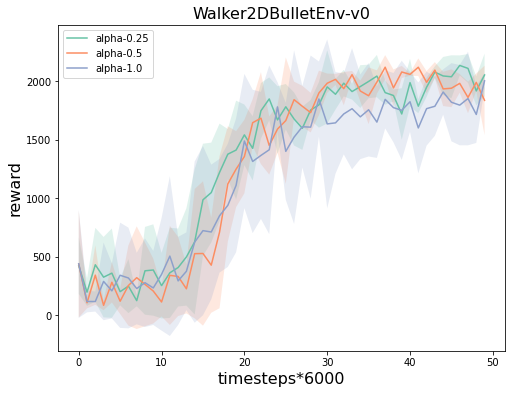

In [85]:
plot_with_conf(results_alpha_walker, 'bc_mse_variance_reward_curve', "Walker2DBulletEnv-v0", "reward")

3
[[-0.5589766996288735, -0.5793267589263011, -0.44922092939740005, -0.37402140343316814, -0.1433539441924535, 0.044857963388438914, -0.0255603327607936, 0.10771150860615296, 0.13518251746759918, 0.1367400985826187, 0.26612995273516743, 0.3752820581810713, 0.27340314113379666, 0.2509991844579761, 0.21902120208009876, 0.4054992174339399, 0.3514897130119755, 0.4309416199369996, 0.41290107358149264, 0.4478958423824653, 0.506420955833857, 0.4962055592728582, 0.4729604979236781, 0.4747571410846351, 0.5409522941219163, 0.48602192560043894, 0.4856737911362054, 0.5615083613756153, 0.5209069577918675, 0.5290728994817595, 0.4958861436059946, 0.5676291672331951, 0.4918064352599708, 0.4815885143654092, 0.5362967986978939, 0.5446042884651098, 0.5540947233309609, 0.4833768484846575, 0.6356718748749994, 0.4184271038694584, 0.5411269791213446, 0.5790147315428047, 0.5770803374111084, 0.6775694429959679, 0.5656930444027691, 0.5535381690914789, 0.5855939418135899, 0.5731810234370298, 0.5847908131311911, 

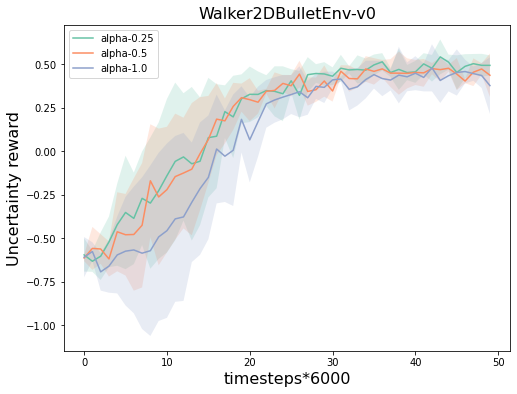

In [86]:
plot_with_conf(results_alpha_walker, 'bc_variance_u_reward_curve', "Walker2DBulletEnv-v0", "Uncertainty reward")

In [87]:
results_alpha_cheetah = {"alpha-0.25":load_results(3, "HalfCheetahBulletEnv-v0", "True", "0.25"), "alpha-0.5":load_results(3, "HalfCheetahBulletEnv-v0", "True", "0.5"),
                        "alpha-1.0":load_results(3, "HalfCheetahBulletEnv-v0", "True", "1")}

3
[[1585.7131988, 920.7151654999999, 1322.4114905, 2198.0156545, 1739.7216332999994, 2201.9904079999997, 1887.6055537999998, 2160.6548703000003, 2049.5596726, 2514.2123199, 2440.5546733, 2016.1470822, 2214.1693632, 2412.2398921999998, 2724.0108408000006, 2080.484745200001, 2089.6778726, 2524.6946931999996, 2124.8679970000007, 2566.8183101, 2189.6289803000004, 2206.023521, 2441.6909481999996, 2775.2278804, 2241.7686938000006, 2438.6106905, 2458.5235008000004, 2424.0389026000003, 2276.9056985, 2688.5024797, 2741.8443112, 2622.2312185999995, 1669.0448623, 2507.0797453, 2400.5582874, 2291.1185952, 2458.3021627000007, 2942.0721118, 2495.368756, 2689.3359673, 2420.0701834999995, 2077.5448379, 2624.230518600001, 2479.7844585000003, 2197.9230881999997, 2897.6839034000004, 2505.1988306, 2626.4453097000005, 2265.976419, 2845.6440373], [2510.7267034, 2883.4652241, 2541.0058024, 2272.6727761, 2740.3941943000004, 2622.0153486, 2621.650063100001, 2648.8820185, 2401.510787800001, 2654.1604206, 2542.8

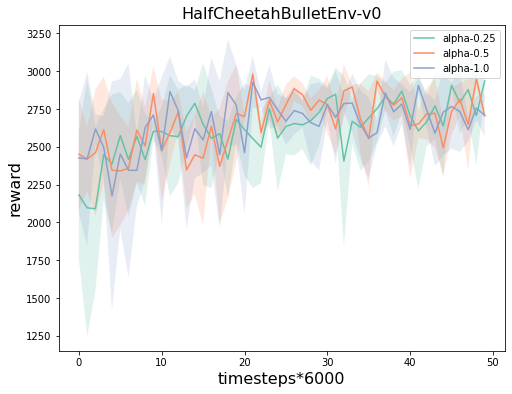

In [88]:
plot_with_conf(results_alpha_cheetah, 'bc_mse_variance_reward_curve', "HalfCheetahBulletEnv-v0", "reward")

3
[[0.177, 0.21125, 0.2922, 0.34219999999999995, 0.3734, 0.3776, 0.4164, 0.4375999999999999, 0.467, 0.4938, 0.5072000000000001, 0.5232000000000001, 0.5602, 0.5606000000000001, 0.5748, 0.5763999999999998, 0.5814, 0.6078, 0.626, 0.6164, 0.6158, 0.6344000000000001, 0.6442, 0.6526000000000001, 0.6537999999999999, 0.6563999999999999, 0.6688000000000001, 0.6786000000000001, 0.6724, 0.7017999999999999, 0.6878, 0.6841999999999999, 0.6642000000000001, 0.6628000000000001, 0.687, 0.6984000000000001, 0.6973999999999999, 0.7030000000000001, 0.6882, 0.6978, 0.6859999999999999, 0.6928, 0.6852, 0.6843999999999999, 0.6862, 0.6908000000000001, 0.669, 0.679, 0.6933999999999999, 0.6898], [0.14800000000000002, 0.16274999999999998, 0.2666, 0.3582, 0.3782, 0.4316, 0.4942, 0.5268, 0.5652, 0.5736, 0.5536, 0.5698, 0.5746, 0.5952, 0.6328, 0.6208, 0.6416000000000001, 0.6365999999999999, 0.6402000000000001, 0.6734, 0.6684, 0.6072, 0.6948, 0.6876, 0.6858, 0.6859999999999999, 0.6880000000000001, 0.6654, 0.6964, 0.74

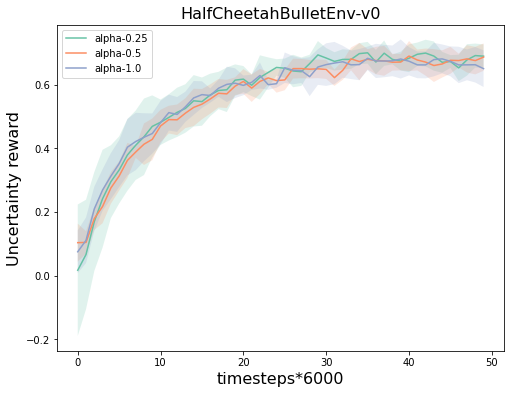

In [89]:
plot_with_conf(results_alpha_cheetah, 'bc_variance_u_reward_curve', 'HalfCheetahBulletEnv-v0', 'Uncertainty reward')

In [90]:
results_alpha_cheetah_warm = {"BC+DRIL":load_results(3, "HalfCheetahBulletEnv-v0", "True", "1"), 
                        "DRIL":load_results(3, "HalfCheetahBulletEnv-v0", "False", "1")}

In [91]:
print(results_alpha_cheetah_warm)

{'BC+DRIL': {'expert': array([2937.52446267, 2923.540875  , 3077.13917967]), 'bc_mse': array([2140.900017 , 2831.2043093]), 'bc_mse_variance': array([2616.8928176, 2908.5475016, 2599.4412606]), 'bc_variance_u_reward_curve': [[0.12, 0.13699999999999998, 0.1932, 0.2422, 0.30300000000000005, 0.3582, 0.3886, 0.4148000000000001, 0.4168, 0.445, 0.4816, 0.5042000000000001, 0.5068, 0.5252000000000001, 0.5446, 0.5464, 0.5616, 0.575, 0.5726000000000001, 0.5762, 0.5854, 0.5882, 0.6073999999999999, 0.6098, 0.5908, 0.6038000000000001, 0.6076, 0.621, 0.5920000000000001, 0.6192, 0.6093999999999999, 0.6292, 0.6474, 0.6334, 0.6398, 0.6518000000000002, 0.6232, 0.6272, 0.6348, 0.6496000000000001, 0.655, 0.6342, 0.6174, 0.6304, 0.6374000000000001, 0.6462, 0.6599999999999999, 0.6304000000000001, 0.615, 0.6077999999999999], [0.124, 0.1825, 0.3018, 0.3584, 0.4052, 0.4384, 0.5184, 0.5346, 0.5346, 0.5242, 0.5642, 0.5845999999999999, 0.573, 0.5908000000000001, 0.629, 0.6272, 0.595, 0.626, 0.6784000000000001, 0.

3
[[0.12, 0.13699999999999998, 0.1932, 0.2422, 0.30300000000000005, 0.3582, 0.3886, 0.4148000000000001, 0.4168, 0.445, 0.4816, 0.5042000000000001, 0.5068, 0.5252000000000001, 0.5446, 0.5464, 0.5616, 0.575, 0.5726000000000001, 0.5762, 0.5854, 0.5882, 0.6073999999999999, 0.6098, 0.5908, 0.6038000000000001, 0.6076, 0.621, 0.5920000000000001, 0.6192, 0.6093999999999999, 0.6292, 0.6474, 0.6334, 0.6398, 0.6518000000000002, 0.6232, 0.6272, 0.6348, 0.6496000000000001, 0.655, 0.6342, 0.6174, 0.6304, 0.6374000000000001, 0.6462, 0.6599999999999999, 0.6304000000000001, 0.615, 0.6077999999999999], [0.124, 0.1825, 0.3018, 0.3584, 0.4052, 0.4384, 0.5184, 0.5346, 0.5346, 0.5242, 0.5642, 0.5845999999999999, 0.573, 0.5908000000000001, 0.629, 0.6272, 0.595, 0.626, 0.6784000000000001, 0.6704000000000001, 0.6401999999999999, 0.6408, 0.6856, 0.6123999999999999, 0.6202, 0.718, 0.7074, 0.6986, 0.7108, 0.7343999999999999, 0.7572000000000001, 0.7612, 0.7418, 0.7251999999999998, 0.731, 0.7343999999999999, 0.7487

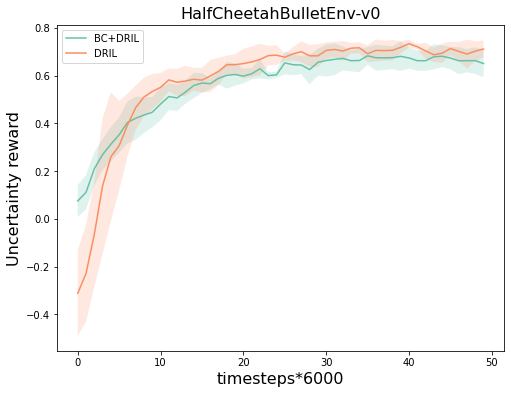

In [92]:
plot_with_conf(results_alpha_cheetah_warm, 'bc_variance_u_reward_curve', "HalfCheetahBulletEnv-v0", "Uncertainty reward")

3
[[1964.3656662, 1608.1993920999998, 2480.0271158, 2274.6319323, 1130.8907822, 1762.9115903000004, 1344.3715388, 2263.6772853, 2138.0674035, 2577.446616, 1789.0359188000002, 2559.1770476, 2479.5541008, 1790.8133149999999, 2719.2402424, 2256.3217382, 2262.0487607999994, 1797.0954315000006, 2396.8377868000002, 2612.2034292, 1985.560727, 2789.6541189, 2861.5213695, 2541.2811674000004, 2600.6618421999997, 2466.7906002000004, 2554.2731692, 2729.2610393000004, 2329.8059304000008, 2231.9830527, 2633.4916726, 2269.2802254000007, 2738.3320738, 2593.3024762, 2701.8163626999994, 2182.4650715999996, 2505.0130480999997, 2588.4955735999997, 2431.3768869000005, 2615.3680825, 2348.739498, 2902.1637449, 2577.5099441999996, 2305.9094571, 2747.1360233000005, 2410.8097982, 2391.3897244000004, 2500.1780274, 2741.8162045000004, 2616.8928176], [2444.5736005, 2807.7511427, 2696.3288907, 2771.9411010000003, 2495.990651, 2898.5529389000008, 2822.6554206000005, 2670.2489256999997, 2868.6193439, 2724.74241349999

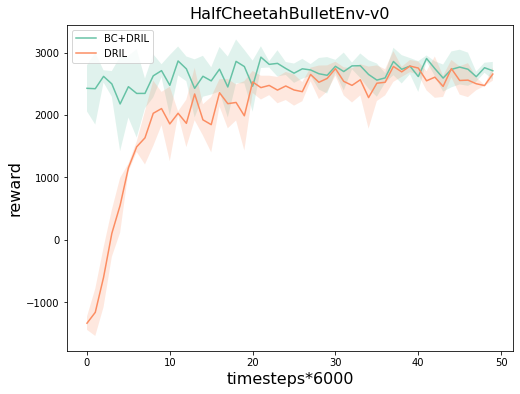

In [93]:
plot_with_conf(results_alpha_cheetah_warm, 'bc_mse_variance_reward_curve', "HalfCheetahBulletEnv-v0", "reward")

In [94]:
def plot_with_bar(arr_values, title, ylabel):
    y = []
    y_std = []
    x = []
    # sns.set_palette("Set2")
    fig = plt.figure(figsize=(8, 6))
    
    for key, item in arr_values.items(): 
        y.append(numpy.mean(item))
        y_std.append(numpy.std(item))
        x.append(key)

    # colors = plt.cm.get_cmap('viridis_r', len(x))
    print(len(x))
    plt.title(title, size=16)
    plt.ylabel(ylabel, size=16)
    plt.bar(x, y, yerr=y_std, capsize=4)
    # plt.bar(x, y, yerr=y_std, capsize=4, color=colors(numpy.arange(len(x))))
    plt.show()


In [95]:
# res = load_results(3, "HalfCheetahBulletEnv-v0", "True", "1")
# pass_arr = [res['expert'], res['bc_mse'], res['bc_mse_variance']]
# # print(pass_arr)
# plot_with_bar(pass_arr)

3


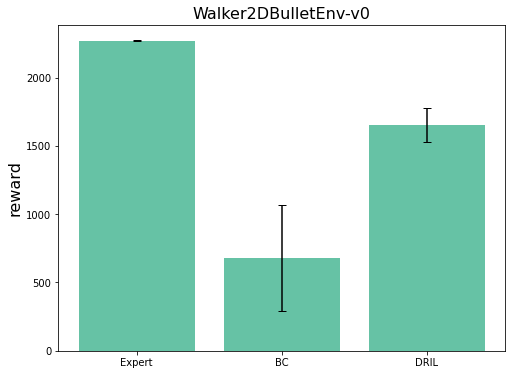

In [96]:
res = load_results(3, "Walker2DBulletEnv-v0", "True", "1")
res2 = load_results(3, "Walker2DBulletEnv-v0", "False", "1")
pass_arr = {'Expert':res['expert'], 'BC':res['bc_mse'], 'DRIL':res2['bc_mse_variance']}
# print(pass_arr)
plot_with_bar(pass_arr, "Walker2DBulletEnv-v0", "reward")
# plot_with_bar(pass_arr, title, y-axis)

3


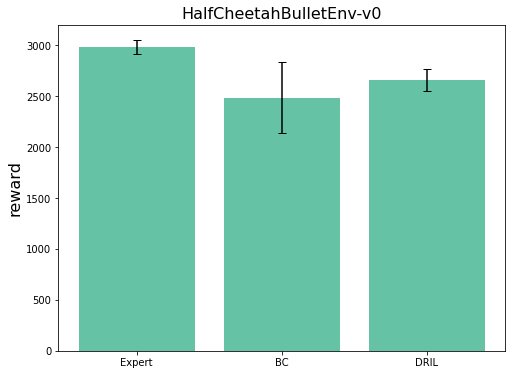

In [97]:
res2 = load_results(3, "HalfCheetahBulletEnv-v0", "False", "1")
pass_arr = {'Expert':res2['expert'], 'BC':res2['bc_mse'], 'DRIL':res2['bc_mse_variance']}
# print(pass_arr)
plot_with_bar(pass_arr, "HalfCheetahBulletEnv-v0", "reward")

6


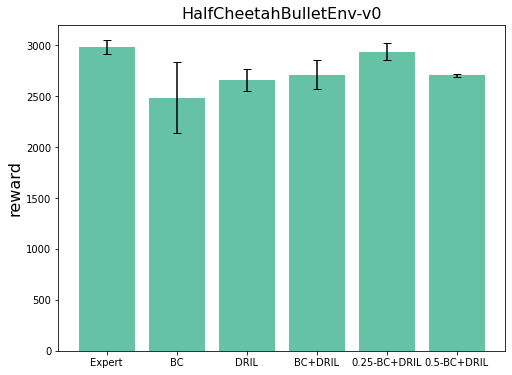

In [98]:
sns.set_palette("Set2")
res2 = load_results(3, "HalfCheetahBulletEnv-v0", "False", "1")
res3 = load_results(3, "HalfCheetahBulletEnv-v0", "True", "1")
res4 = load_results(3, "HalfCheetahBulletEnv-v0", "True", "0.25")
res5 = load_results(3, "HalfCheetahBulletEnv-v0", "True", "0.5")
pass_arr = {'Expert':res2['expert'], 'BC':res2['bc_mse'], 'DRIL':res2['bc_mse_variance'], 'BC+DRIL':res3['bc_mse_variance'], 
            '0.25-BC+DRIL':res4['bc_mse_variance'], '0.5-BC+DRIL':res5['bc_mse_variance']}
# print(pass_arr)
plot_with_bar(pass_arr, "HalfCheetahBulletEnv-v0", "reward")

6


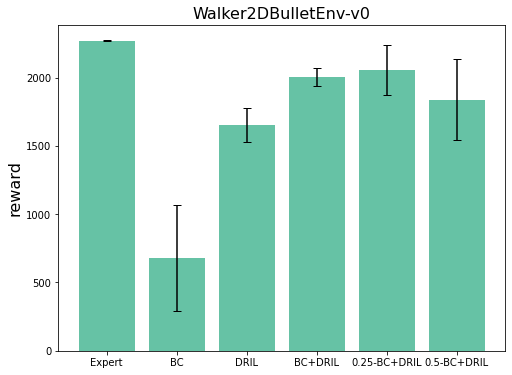

In [99]:
sns.set_palette("Set2")
res2 = load_results(3, "Walker2DBulletEnv-v0", "False", "1")
res3 = load_results(3, "Walker2DBulletEnv-v0", "True", "1")
res4 = load_results(3, "Walker2DBulletEnv-v0", "True", "0.25")
res5 = load_results(3, "Walker2DBulletEnv-v0", "True", "0.5")
pass_arr = {'Expert':res2['expert'], 'BC':res2['bc_mse'], 'DRIL':res2['bc_mse_variance'], 'BC+DRIL':res3['bc_mse_variance'], 
            '0.25-BC+DRIL':res4['bc_mse_variance'], '0.5-BC+DRIL':res5['bc_mse_variance']}
# print(pass_arr)
plot_with_bar(pass_arr, "Walker2DBulletEnv-v0", "reward")

In [100]:
def load_results_shuffle(n_demo, env, warm, alpha):
    # Expert results -----------------
    # expert_results = glob.glob(f'{data_dir}/expert/expert_{env}_seed=*.perf')
    # (expert_reward, _, _, _) = get_results(expert_results)

    # # Behavior Cloing results --------
    # bc_mse_results = glob.glob(f'{data_dir}/bc/bc_{env}_policy_ntrajs={n_demo}_seed=*.perf')
    # (bc_mse_reward, _, _,_) = get_results(bc_mse_results)

    # DRIL results -------------------
    exp_name  = f'dril_{env}_ntraj={n_demo}_ensemble_lr=0.00025_lr=0.00025_bcep=1000_'
    exp_name += f'shuffle=no_shuffle_quantile=0.98_warm={warm}_alpha={alpha}_sample=no_shuffle_cost_-1_to_1_seed=*.perf'


    bc_mse_variance_results = glob.glob(f'{data_dir}/dril/{exp_name}')
    (bc_mse_variance_reward, bc_variance_u_reward, bc_variance_steps, bc_mse_variance_reward_curve) = get_results(bc_mse_variance_results, filter=True)
    

    return { #'expert': numpy.array(expert_reward),
             #'bc_mse': numpy.array(bc_mse_reward),
            'bc_mse_variance': numpy.array(bc_mse_variance_reward),
            'bc_variance_u_reward_curve': bc_variance_u_reward,
            'bc_mse_variance_reward_curve': bc_mse_variance_reward_curve,
            'bc_variance_steps': bc_variance_steps,
            #'random': numpy.array(random_reward),
            }

In [101]:
res_shuffle = {"Random Init": load_results_shuffle(3, "Walker2DBulletEnv-v0", "False", "1"), "Replacement":load_results(3, "Walker2DBulletEnv-v0", "False", "1")}

3
[[13.060934, 11.1481406, 9.841160400000001, 8.860779800000001, 8.8733623, 8.774692300000002, 8.8045656, 8.775010299999998, 8.7928357, 8.660737000000001, 10.9463348, 65.05252929999999, 72.19362659999999, 374.18891060000004, 346.9149863, 692.3575525, 862.4346499000002, 1051.403136, 1428.2921319000004, 1333.2012128, 1517.4023895999999, 1698.8731817999999, 1762.0706593999996, 1580.4031077000004, 1496.2569775999998, 2206.6249683999995, 1986.2829639000001, 1827.4477511, 1804.3904536, 1795.0919526000002, 2007.4472625, 1662.6951693000005, 1809.4579939, 1807.1375489, 1624.0505669000001, 1816.1167459000003, 1643.3821590999999, 1630.4432632, 1828.9531206999993, 1833.3404963, 1842.4594349, 1823.5181860999999, 2054.5127814, 1800.7401311999995, 2061.363571, 1832.9039933, 1865.3905186000002, 2050.8028752, 2173.5824229000004, 2063.0515609], [13.7942381, 12.226427099999999, 10.792417, 10.7305972, 10.6623547, 10.691601, 10.4148737, 10.3357474, 10.3759279, 10.3906693, 10.406995, 10.4789352, 10.5271864,

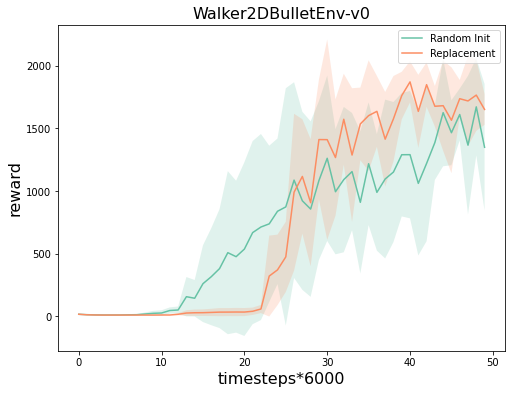

In [102]:
plot_with_conf(res_shuffle, 'bc_mse_variance_reward_curve', "Walker2DBulletEnv-v0", "reward")

3
[[-0.7061904761904761, -0.6904761904761905, -0.6914285714285715, -0.6228571428571428, -0.6066666666666667, -0.6599999999999999, -0.32666666666666666, -0.24761904761904766, -0.3466666666666667, -0.0066666666666666645, -0.020952380952380945, -0.06047259444318269, 0.047262769720286264, 0.12249076843543442, 0.22751743573984035, 0.11004885849323302, 0.3159694072935008, 0.390492687695607, 0.4084184531591541, 0.36405213592182256, 0.4394196421828779, 0.26757273516500146, 0.4799534775055602, 0.4671417444357978, 0.4833256045562132, 0.4092002386825241, 0.4722784744025092, 0.4995800808589028, 0.5606318942029185, 0.5060461889108685, 0.4343076546331364, 0.3939526620665669, 0.5515169307139439, 0.5742683192847062, 0.5898659573583006, 0.5367795262323722, 0.6185852146551127, 0.4982057797459771, 0.6064657356644221, 0.6195170298857907, 0.5914722787690625, 0.5192633727645908, 0.5153089567080545, 0.5347602486915317, 0.6387788967844445, 0.38210867924123376, 0.6095034041590723, 0.5440408974026626, 0.4813100

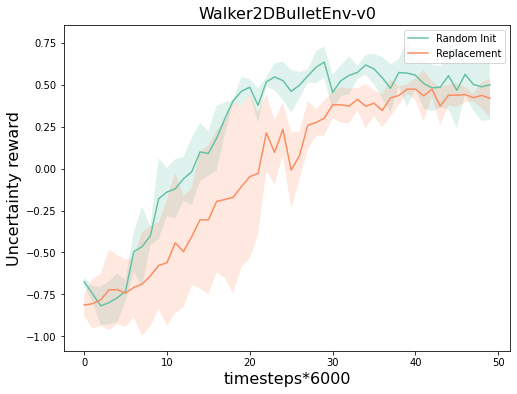

In [103]:
plot_with_conf(res_shuffle, 'bc_variance_u_reward_curve', "Walker2DBulletEnv-v0", "Uncertainty reward")

In [104]:
res_shuffle = {"Random Init": load_results_shuffle(3, "HalfCheetahBulletEnv-v0", "False", "1"), "Replacement":load_results(3, "HalfCheetahBulletEnv-v0", "False", "1")}

3
[[-1357.109666, -1313.5733189000002, 37.87286629999996, 421.27160140000007, 772.2284879, 1121.4119103999997, 1596.2065063, 2018.0509119, 2081.1118469000007, 1655.4473008, 1240.4463104, 1604.0853787, 1431.9732655, 2062.6156494, 1815.3955024, 1655.3100762, 1436.8793672, 2269.0569879, 1450.8582772, 2137.7239352999995, 1599.3426654999998, 1131.8248198999995, 2105.4454318, 1622.0299888000004, 1122.7298938, 2035.9969053, 1438.8123319, 2308.8033355, 1771.5349635000002, 2416.6360733, 1447.0957732000002, 2362.8772071999997, 1571.4604815, 1939.9685118000007, 1779.1325296999996, 1640.6362109999998, 1874.3967950999997, 1962.7945075, 2025.0587802, 2387.927959600001, 2179.1632903, 2245.0630124000004, 2120.5457986999995, 2189.2796799000002, 2367.505615400001, 2131.9467497, 2203.7821205, 2323.8862246, 2172.0127731, 2522.6540511999997], [-1357.1713111, -1466.2064097999998, -1506.8240959, 324.1111818, 1037.3923137, 868.1753355999998, 1501.7528202, 1788.3547671, 2116.4995889, 2423.6064199, 2371.1596933

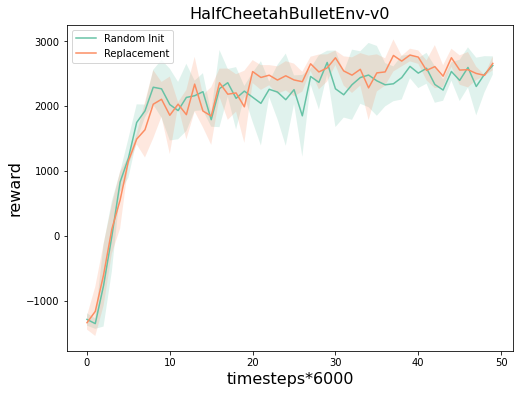

In [105]:
plot_with_conf(res_shuffle, 'bc_mse_variance_reward_curve', "HalfCheetahBulletEnv-v0", "reward")

3
[[0.512, 0.59425, 0.6519999999999999, 0.7, 0.7440000000000001, 0.7764, 0.7889999999999999, 0.8258000000000001, 0.8450000000000001, 0.8552000000000002, 0.8614, 0.8577999999999999, 0.8648, 0.8682000000000001, 0.8792, 0.8722, 0.8686, 0.8736, 0.8782, 0.8796000000000002, 0.8878, 0.8806, 0.8752000000000001, 0.8790000000000001, 0.8758000000000001, 0.8799999999999999, 0.8824, 0.8783999999999998, 0.8782, 0.889, 0.8819999999999999, 0.8748000000000001, 0.8692, 0.8794000000000001, 0.8724000000000001, 0.8667999999999999, 0.8748000000000001, 0.8778, 0.8766, 0.8746, 0.8724000000000001, 0.8747999999999999, 0.8657999999999999, 0.8607999999999999, 0.8648, 0.8596, 0.8542, 0.8622, 0.8706000000000002, 0.8698], [0.368, 0.4005, 0.5267999999999999, 0.627, 0.6792, 0.7088, 0.7468, 0.75, 0.77, 0.7862, 0.7908000000000001, 0.7974000000000001, 0.8039999999999999, 0.8019999999999999, 0.8192, 0.8170000000000001, 0.8301999999999999, 0.8442000000000001, 0.8513999999999999, 0.8168, 0.8135999999999999, 0.82100000000000

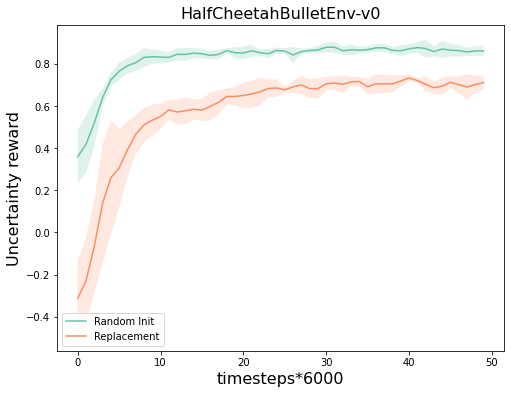

In [107]:
plot_with_conf(res_shuffle, 'bc_variance_u_reward_curve', "HalfCheetahBulletEnv-v0", "Uncertainty reward")